In [236]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest, f_classif
import pylab
import scipy
import sklearn
import time
import seaborn as sns
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

In [237]:
pd.set_option("display.max_rows", 250000)

In [238]:
df = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/GSE59114.csv', header = 1)
df1 = df.T
df1.columns = df1.loc['Gene Symbol'].reset_index()
df1 = df1.drop(['Gene Symbol', 'UCSC transcripts'])
df1.columns = [x[1] for x in df1.columns]
df1.columns = df1.columns.str.replace("'", "")
df1.shape

(1434, 8422)

Itgam, Ly6g, Ptprc, Cd3e, Ly76, Kit, Ly6a, Cd48, Slamf1

In [239]:
import re
df1_1 = df1[~df1.index.str.contains('biol_replicate')]
df1_1 = df1_1.drop(['\'Young LT-HSC\'','\'Young ST-HSC\'', '\'Young MPP\'','\'Old LT-HSC\'', '\'Old ST-HSC\'','Old MPP\''])
df1_1 = df1_1.drop(['Itgam', 'Ptprc', 'Kit', 'Ly6a', 'Cd48', 'Slamf1'], axis = 1)

In [240]:
df1_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1058 entries, young_LT_HSC_2 to old_MPP_168
Columns: 8416 entries, Npl to Sft2d1
dtypes: object(8416)
memory usage: 67.9+ MB


In [241]:
df1_1.index = df1_1.index.str.replace(r'[^a-zA-Z]', '')

print((df1_1.columns).shape)
print(np.unique(df1_1.columns).shape)

(8416,)
(8351,)


In [242]:
df1_1dup = df1_1[df1_1.loc[:,df1_1.columns.duplicated()].columns]


In [243]:
dupcols = np.unique(df1_1dup.columns)
dupcols

array(['Abcg2', 'Arih1', 'Atf7ip', 'Atrip', 'Brwd1', 'Cbx1', 'Ccnd3',
       'Cdk6', 'Celf1', 'Commd1', 'Csnk1a1', 'Ctse', 'Dnajb6', 'Eci2',
       'Eif1ax', 'Fgd4', 'Fus', 'G3bp1', 'Glod4', 'Gm10598', 'Gm13215',
       'Hjurp', 'Ikbkb', 'Ing4', 'Itga4', 'Itga6', 'Kansl2', 'Lcor',
       'Lrrc29', 'Luc7l2', 'Mafg', 'Mecom', 'Mob1a', 'Mtcp1', 'Nagk',
       'Ndufa3', 'Pafah1b1', 'Patz1', 'Pcif1', 'Pik3ip1', 'Psme4', 'Pten',
       'Ramp2', 'Rpl24', 'Rspry1', 'Satb1', 'Smarcc2', 'Srcap', 'Srsf10',
       'Sugp2', 'Taf9', 'Tex261', 'Tmem167b', 'Tmem181b-ps', 'Trappc9',
       'Trim30b', 'U2af1l4', 'Utp23', 'Wwp2', 'Zbtb20', 'Zfp708',
       'Zfp869', 'Zgpat'], dtype=object)

In [244]:
df1_1dupgroup = df1_1dup.groupby(df1_1dup.columns, axis=1).sum()

In [245]:
df1_1dupmean = pd.DataFrame()
for x in dupcols:
    df1_1dupmean[x] = df1_1dupgroup[x]/df1_1dup.columns.tolist().count(x)


In [246]:
# cols = []
# n = 1
# for x in df2dup.columns:
#     if x in cols:
#         cols.append(x+'.'+str(n))
#         n += 1
#     else:
#         cols.append(x)
#         n = 1


In [262]:
dfnodup = df1_1.loc[:,~df1_1.columns.duplicated()].drop(dupcols, axis = 1)

df2 = pd.concat([dfnodup, df1_1dupmean], axis = 1).astype(np.float64)

df2= df2.round(2)
df2.shape

(1058, 8351)

In [263]:
y = [x for x in df2.index]

k = 20
kbest = SelectKBest(k=k, score_func=f_classif)
X_best_feat = kbest.fit_transform(df2,y)

X_best_feat = pd.DataFrame(X_best_feat, columns=df2.columns[kbest.get_support()])

trimcol = X_best_feat.columns
trimcol


Index(['Sell', 'Pdcd4', 'Cd34', 'Gnb1', 'Plac8', 'Flt3', 'Cbx3', 'Mmrn1',
       'BC035044', 'Nkg7', 'Nupr1', 'Sult1a1', 'Arglu1', 'Gpr97', 'uc012hdk.1',
       'Tespa1', 'Mpo', 'Eif1', 'Zfp187', 'Sod1'],
      dtype='object')

In [264]:
genefracs = (df2==0).sum()/(df2==0).count()
passindex = genefracs[genefracs < 0.95]


In [265]:
zifa = df2[passindex.index]
zifa= np.round(zifa.astype(np.float64),4)
zifa = np.array(zifa)
zifa.shape

(1058, 8240)

In [266]:
zifabest = df2[trimcol]
zifabest= np.round(zifabest.astype(np.float64),4)
zifabest = np.array(zifabest)
zifabest.shape

(1058, 20)

In [267]:
from ZIFA import ZIFA
from ZIFA import block_ZIFA

In [268]:
start_time = time.time()
Zbest, model_params = block_ZIFA.fitModel(zifabest, 5)
print("--- %s seconds ---" % (time.time() - start_time))

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1058, D = 20, K = 5, n_blocks = 1
Block sizes [20]
Param change below threshold 1.000e-02 after 4 iterations
--- 8.04499626159668 seconds ---


In [269]:
start_time = time.time()
Z, model_params = block_ZIFA.fitModel(zifa, 5)
print("--- %s seconds ---" % (time.time() - start_time))

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 16
Running block zero-inflated factor analysis with N = 1058, D = 8240, K = 5, n_blocks = 16
Block sizes [515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515]
Param change below threshold 1.000e-02 after 12 iterations
--- 1743.246695280075 seconds ---


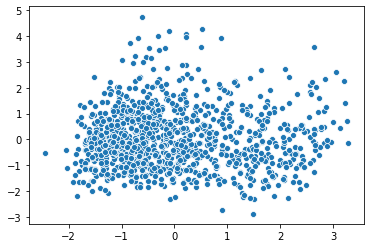

In [270]:
dfz = pd.DataFrame(Z, index = df2.index)
pcaz = PCA(n_components=3, random_state = 42)

zcomps = pcaz.fit_transform(dfz)
sns.scatterplot(zcomps[:,0], zcomps[:,1])
plt.show()

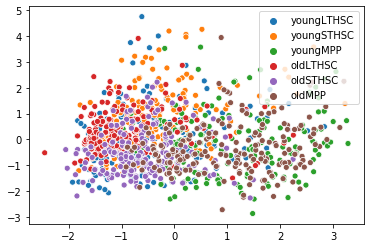

In [271]:
sns.scatterplot(zcomps[:,0], zcomps[:,1], hue = dfz.index)
plt.show()

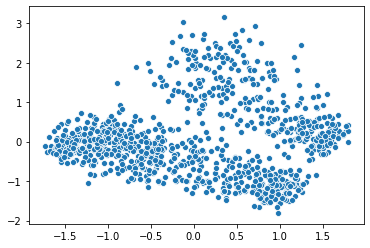

In [272]:
dfzbest = pd.DataFrame(Zbest, index = df2.index)
pcazbest = PCA(n_components=3, random_state = 42)

zcompsbest = pcazbest.fit_transform(dfzbest)
sns.scatterplot(zcompsbest[:,0], zcompsbest[:,1])
plt.show()

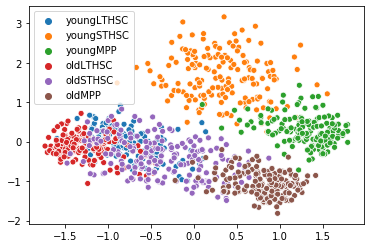

In [273]:
sns.scatterplot(zcompsbest[:,0], zcompsbest[:,1], hue = dfz.index)
plt.show()

In [274]:
encoded = {'oldLTHSC':0, 'oldMPP':1, 'oldSTHSC':2, 'youngLTHSC':3, 'youngMPP':4, 'youngSTHSC':5}
cells = ['oldLTHSC' ,'oldMPP', 'oldSTHSC', 'youngLTHSC' ,'youngMPP' ,'youngSTHSC']
cell_types = [encoded.get(x, x) for x in dfz.index]
colormap = ['r', 'b', 'g', 'y', 'c', 'm']
cell_colors = [colormap[x] for x in cell_types]
dfpca = pd.DataFrame(zcomps, index = dfz.index)
dfpca
fig = px.scatter_3d(dfpca, zcomps[:,0], zcomps[:,1],zcomps[:,2], dfpca.index)
fig.update_traces(marker=dict(opacity =1, size=4,
                              line=dict(width= .1)))

fig.show()

In [275]:
encoded = {'oldLTHSC':0, 'oldMPP':1, 'oldSTHSC':2, 'youngLTHSC':3, 'youngMPP':4, 'youngSTHSC':5}
cells = ['oldLTHSC' ,'oldMPP', 'oldSTHSC', 'youngLTHSC' ,'youngMPP' ,'youngSTHSC']
cell_types = [encoded.get(x, x) for x in dfz.index]
colormap = ['r', 'b', 'g', 'y', 'c', 'm']
cell_colors = [colormap[x] for x in cell_types]
dfpcabest = pd.DataFrame(zcompsbest, index = dfz.index)
dfpcabest
fig = px.scatter_3d(dfpcabest, zcompsbest[:,0], zcompsbest[:,1],zcompsbest[:,2], dfpcabest.index)
fig.update_traces(marker=dict(opacity =1, size=4,
                              line=dict(width= .1)))

fig.show()

In [276]:
np.cov(dfz)

array([[ 0.07436564,  0.19027949,  0.10535263, ..., -0.15203316,
        -0.12899996, -0.26997777],
       [ 0.19027949,  0.58060167,  0.32435977, ..., -0.50177089,
        -0.43450335, -0.85779429],
       [ 0.10535263,  0.32435977,  0.31326212, ..., -0.23511656,
        -0.25676113, -0.5671696 ],
       ...,
       [-0.15203316, -0.50177089, -0.23511656, ...,  0.51577721,
         0.53927216,  0.79029056],
       [-0.12899996, -0.43450335, -0.25676113, ...,  0.53927216,
         0.79027092,  0.86030588],
       [-0.26997777, -0.85779429, -0.5671696 , ...,  0.79029056,
         0.86030588,  1.42190013]])

Text(0.5, 1.0, 'ZIFA-UMAP (5 dim): genes with fewer than 95% zeros')

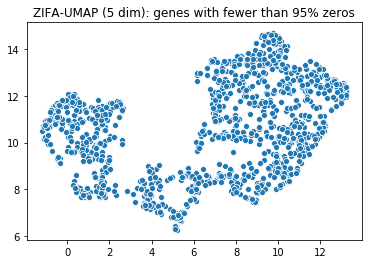

In [277]:
zumap = umap.UMAP(n_neighbors=20,
                      min_dist=.2,
                      metric='euclidean').fit_transform(dfz)
fig = sns.scatterplot(zumap[:,0], zumap[:,1])
fig.set_title('ZIFA-UMAP (5 dim): genes with fewer than 95% zeros')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

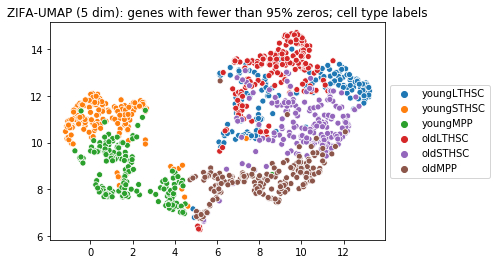

In [278]:
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = dfz.index)
fig.set_title('ZIFA-UMAP (5 dim): genes with fewer than 95% zeros; cell type labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 1.0, 'ZIFA-UMAP (5 dim): 20 kbest genes')

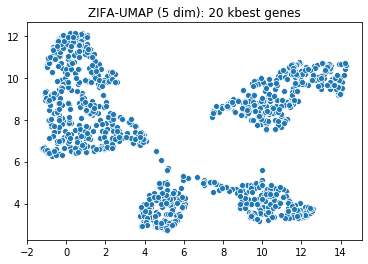

In [279]:
zumapbest = umap.UMAP(n_neighbors=20,
                      min_dist=.2,
                      metric='euclidean').fit_transform(dfzbest)
fig = sns.scatterplot(zumapbest[:,0], zumapbest[:,1])
fig.set_title('ZIFA-UMAP (5 dim): 20 kbest genes')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

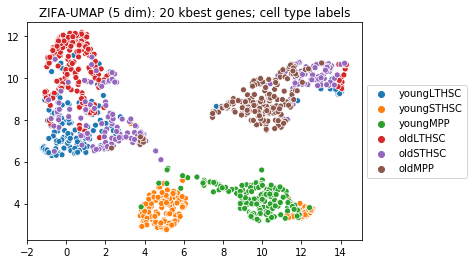

In [280]:
fig = sns.scatterplot(zumapbest[:,0], zumapbest[:,1], hue = dfz.index)
fig.set_title('ZIFA-UMAP (5 dim): 20 kbest genes; cell type labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [281]:
gmm = GaussianMixture(n_components = 6)
gmm.fit(dfz)
cluster = gmm.fit_predict(dfz)


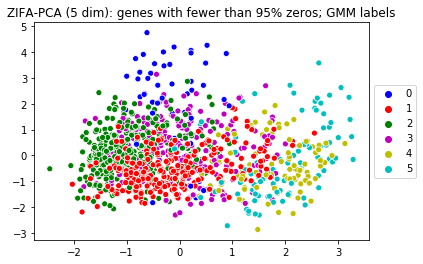

In [282]:
fig = sns.scatterplot(zcomps[:,0], zcomps[:,1], hue = cluster,palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-PCA (5 dim): genes with fewer than 95% zeros; GMM labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

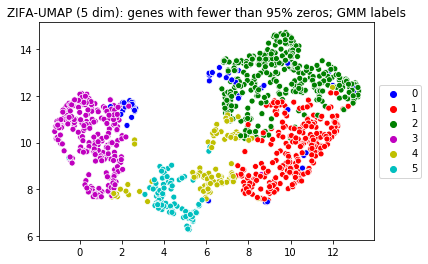

In [283]:
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = cluster,palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-UMAP (5 dim): genes with fewer than 95% zeros; GMM labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [284]:
gmmbest = GaussianMixture(n_components = 6)
gmmbest.fit(dfzbest)
clusterbest = gmmbest.fit_predict(dfzbest)


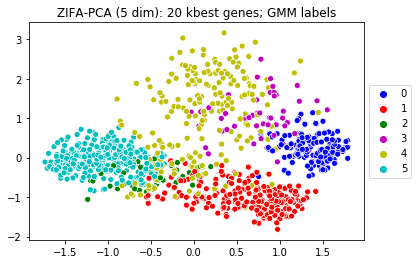

In [285]:
fig = sns.scatterplot(zcompsbest[:,0], zcompsbest[:,1], hue = clusterbest,palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-PCA (5 dim): 20 kbest genes; GMM labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

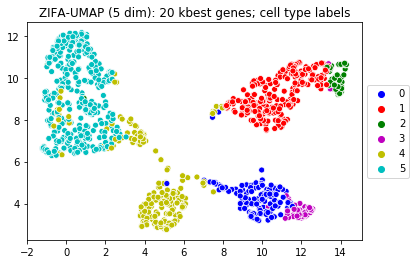

In [286]:
fig = sns.scatterplot(zumapbest[:,0], zumapbest[:,1], hue = clusterbest, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-UMAP (5 dim): 20 kbest genes; cell type labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [287]:
km = KMeans(n_clusters = 6, random_state=42)
kmdata = km.fit_transform(dfz)
kpred = km.fit_predict(dfz)

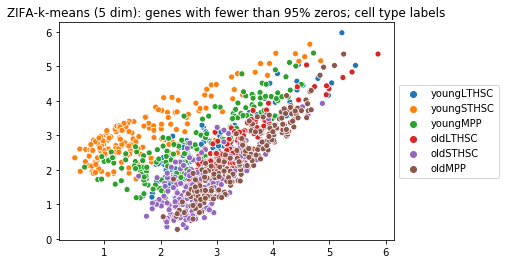

In [288]:
fig = sns.scatterplot(kmdata[:,0], kmdata[:,1], hue = dfz.index)
fig.set_title('ZIFA-k-means (5 dim): genes with fewer than 95% zeros; cell type labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

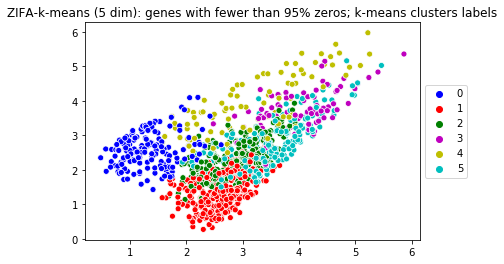

In [289]:
fig = sns.scatterplot(kmdata[:,0], kmdata[:, 1], hue = kpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-k-means (5 dim): genes with fewer than 95% zeros; k-means clusters labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

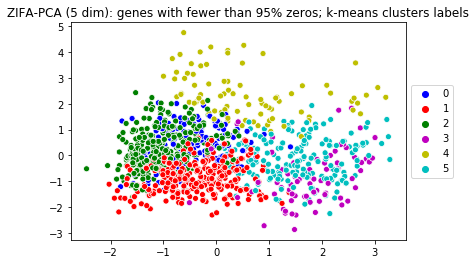

In [290]:
fig = sns.scatterplot(zcomps[:,0], zcomps[:,1], hue = kpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-PCA (5 dim): genes with fewer than 95% zeros; k-means clusters labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

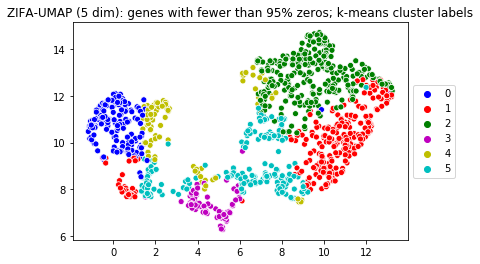

In [291]:
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = kpred,palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-UMAP (5 dim): genes with fewer than 95% zeros; k-means cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [292]:
kmbest = KMeans(n_clusters = 6, random_state=42)
kmdatabest = kmbest.fit_transform(dfzbest)
kpredbest = kmbest.fit_predict(dfzbest)

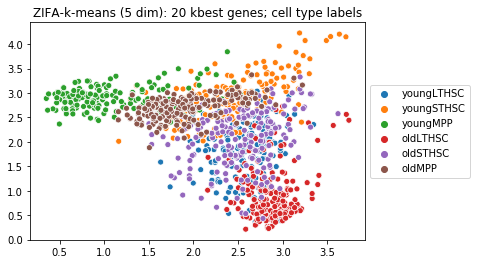

In [293]:
fig = sns.scatterplot(kmdatabest[:,0], kmdatabest[:,1], hue = dfz.index)
fig.set_title('ZIFA-k-means (5 dim): 20 kbest genes; cell type labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

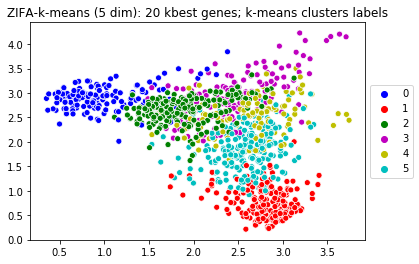

In [294]:
fig = sns.scatterplot(kmdatabest[:,0], kmdatabest[:, 1], hue = kpredbest, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-k-means (5 dim): 20 kbest genes; k-means clusters labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

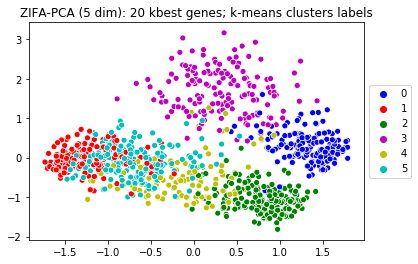

In [295]:
fig = sns.scatterplot(zcompsbest[:,0], zcompsbest[:,1], hue = kpredbest, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-PCA (5 dim): 20 kbest genes; k-means clusters labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

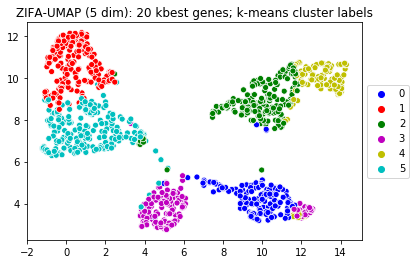

In [296]:
fig = sns.scatterplot(zumapbest[:,0], zumapbest[:,1], hue = kpredbest, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-UMAP (5 dim): 20 kbest genes; k-means cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [297]:
agg = AgglomerativeClustering(n_clusters = 6, affinity='euclidean',linkage = 'complete')
aggdata = agg.fit(dfz)
aggpred = aggdata.labels_

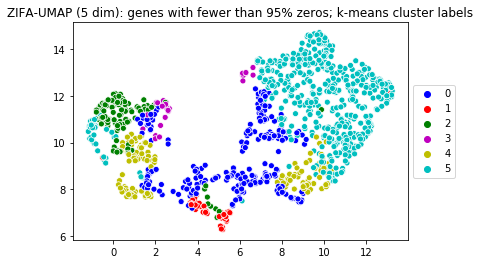

In [298]:
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = aggpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-UMAP (5 dim): genes with fewer than 95% zeros; k-means cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [299]:
aggbest = AgglomerativeClustering(n_clusters = 6, affinity='euclidean',linkage = 'complete')
aggbestdata = aggbest.fit(dfzbest)
aggpredbest = aggbestdata.labels_

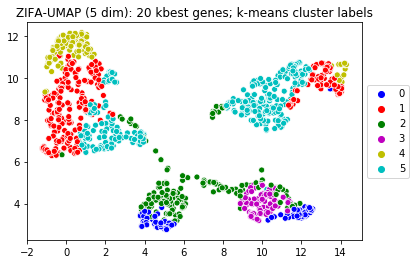

In [300]:
fig = sns.scatterplot(zumapbest[:,0], zumapbest[:,1], hue = aggpredbest, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-UMAP (5 dim): 20 kbest genes; k-means cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

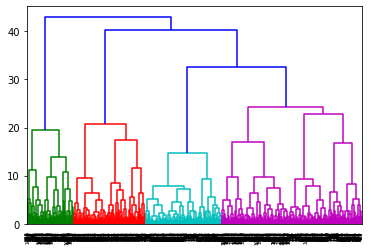

In [301]:
dendrogram(linkage(dfz, method = 'ward'))
plt.show()

In [302]:
dfcelltypes = pd.DataFrame(df2.mean(), columns = ['All cell average'])
dfcelltypes['youngLTHSC'] = df2[df2.index == 'youngLTHSC'].mean()
dfcelltypes['youngSTHSC'] = df2[df2.index == 'youngSTHSC'].mean()
dfcelltypes['youngMPP'] = df2[df2.index == 'youngMPP'].mean()
dfcelltypes['oldLTHSC'] = df2[df2.index == 'oldLTHSC'].mean()
dfcelltypes['oldSTHSC'] = df2[df2.index == 'oldSTHSC'].mean()
dfcelltypes['oldMPP'] = df2[df2.index == 'oldMPP'].mean()


In [303]:
dfcellbroad = pd.DataFrame(df2.mean(), columns = ['All cell average'])
dfcellbroad['HSC'] = df2[df2.index.str.contains('HSC')].mean()
dfcellbroad['MPP'] = df2[df2.index.str.contains('MPP')].mean()
dfcellbroad['HSC/MPP'] = dfcellbroad['HSC']/dfcellbroad['MPP']
#dfcellbroad.sort_values(by = ['HSC/MPP','HSC','MPP'], ascending = False).head(25000)
